In [1]:
%load_ext autoreload
%autoreload 2

# Explaining why so many circuits have a sensitivity of 0.000333

In [2]:
import numpy as np
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common import set_theme

PALETTE = 'viridis'
set_theme()

top_write_dir = os.path.join('data', '26_sensitivity_peak2')

In [3]:
fn_dataset1 = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
df1 = pd.read_csv(fn_dataset1)

In [4]:
dir_sim = os.path.join('..', 'notebooks', 'data', 'simulate_circuits', '2025_09_23__15_41_51')

fn_analytics = os.path.join(dir_sim, 'analytics.json')
with open(fn_analytics, 'r') as f:
    analytics = json.load(f)
    
fn_circuits = '../data/raw/generate_sequence_batch/2025_09_20_103744/circuits/rc.json'
fn_energies = '../data/raw/generate_sequence_batch/2025_09_20_103744/energies.json'

with open(fn_circuits, 'r') as f:
    circuits = json.load(f)
with open(fn_energies, 'r') as f:
    energies = json.load(f)
    
cols_e = [f'$RNA_{i+1}$-$RNA_{j+1}$' for i, j in zip(*np.triu_indices(3))]
energy_keys = sorted(energies.keys(), key=lambda k: int(k.split('_')[1]))


In [5]:
analytics = {k: np.array(v) for k, v in analytics.items()}

In [6]:
df2 = pd.DataFrame()
for i, spec in zip([-3, -2, -1], [f'$RNA_1$', f'$RNA_2$', f'$RNA_3$']):
    df_curr = pd.DataFrame({k: v[:, i] for k, v in analytics.items()})
    df_curr['Sample name'] = spec
    df_curr['circuit_idx'] = np.arange(len(df_curr))
    df2 = pd.concat([df2, df_curr])
df2['Log sensitivity'] = np.log10(df2['sensitivity'])
df2['Log precision'] = np.log10(df2['precision'])

In [7]:
df1['Is at peak'] = df1['sensitivity'] == df1[df1['sample_name'] == 'RNA_2']['sensitivity'].value_counts().reset_index().iloc[0]['sensitivity']
df2['Is at peak'] = df2['sensitivity'] == df2[df2['Sample name'] == f'$RNA_3$']['sensitivity'].value_counts().reset_index().iloc[0]['sensitivity']

In [75]:
max_amount = df1[df1['sample_name'] != 'RNA_0']['max_amount'].value_counts().index[0]
steady_state = df1[df1['sample_name'] != 'RNA_0']['steady_states'].value_counts().index[0]
initial_steady_state = df1[df1['sample_name'] != 'RNA_0']['initial_steady_states'].value_counts().index[0]
steady_state_sig = df1[df1['sample_name'] == 'RNA_0']['steady_states'].value_counts().index[0]
initial_steady_state_sig = df1[df1['sample_name'] == 'RNA_0']['initial_steady_states'].value_counts().index[0]
min_amount_sig = df1[df1['sample_name'] == 'RNA_0']['min_amount'].value_counts().index[0]

sensitivity = np.abs(np.divide(
    (steady_state - initial_steady_state) / initial_steady_state,
    (steady_state_sig - initial_steady_state_sig) / initial_steady_state_sig
))
{'sensitivity': sensitivity,
 'max_amount': max_amount,
 'steady_state': steady_state,
 'initial_steady_state': initial_steady_state,
 'steady_state_sig': steady_state_sig,
 'initial_steady_state_sig': initial_steady_state_sig, 
 'min_amount_sig': min_amount_sig}

{'sensitivity': np.float64(0.00033418855885369706),
 'max_amount': np.float64(199.73245),
 'steady_state': np.float64(199.66588),
 'initial_steady_state': np.float64(199.73245),
 'steady_state_sig': np.float64(398.93137),
 'initial_steady_state_sig': np.float64(199.73245),
 'min_amount_sig': np.float64(199.73245)}

In [73]:
max_amount2 = df2[df2['Sample name'] !=
                  f'$RNA_1$']['max_amount'].value_counts().index[0]
steady_state2 = df2[df2['Sample name'] !=
                    f'$RNA_1$']['steady_states'].value_counts().index[0]
initial_steady_state2 = df2[df2['Sample name'] !=
                            f'$RNA_1$']['initial_steady_states'].value_counts().index[0]
steady_state_sig2 = df2[df2['Sample name'] ==
                        f'$RNA_1$']['steady_states'].value_counts().index[0]
initial_steady_state_sig2 = df2[df2['Sample name'] ==
                                f'$RNA_1$']['initial_steady_states'].value_counts().index[0]
min_amount_sig2 = df2[df2['Sample name'] ==
                                f'$RNA_1$']['min_amount'].value_counts().index[0]

sensitivity2 = np.abs(np.divide(
    (steady_state2 - initial_steady_state2) / initial_steady_state2,
    (steady_state_sig2 - initial_steady_state_sig2) / initial_steady_state_sig2
))
{'sensitivity2': sensitivity2,
 'max_amount2': max_amount2,
 'steady_state2': steady_state2,
 'initial_steady_state2': initial_steady_state2,
 'steady_state_sig2': steady_state_sig2,
 'initial_steady_state_sig2': initial_steady_state_sig2,
 'min_amount_sig2': min_amount_sig2}

{'sensitivity2': np.float64(0.24957088911774805),
 'max_amount2': np.float64(99.86616516113281),
 'steady_state2': np.float64(99.8328857421875),
 'initial_steady_state2': np.float64(99.86616516113281),
 'steady_state_sig2': np.float64(199.46563720703125),
 'initial_steady_state_sig2': np.float64(199.73233032226562),
 'min_amount_sig2': np.float64(199.46563720703125)}

In [74]:
sensitivity2 / sensitivity 
((steady_state2 - initial_steady_state2) / initial_steady_state2) / (
    (steady_state - initial_steady_state) / initial_steady_state)
((steady_state_sig - initial_steady_state_sig) / initial_steady_state_sig) / (
    (steady_state_sig2 - initial_steady_state_sig2) / initial_steady_state_sig2)
(steady_state_sig - initial_steady_state_sig), (steady_state_sig2 - initial_steady_state_sig2)
min_amount_sig2

np.float64(199.46563720703125)

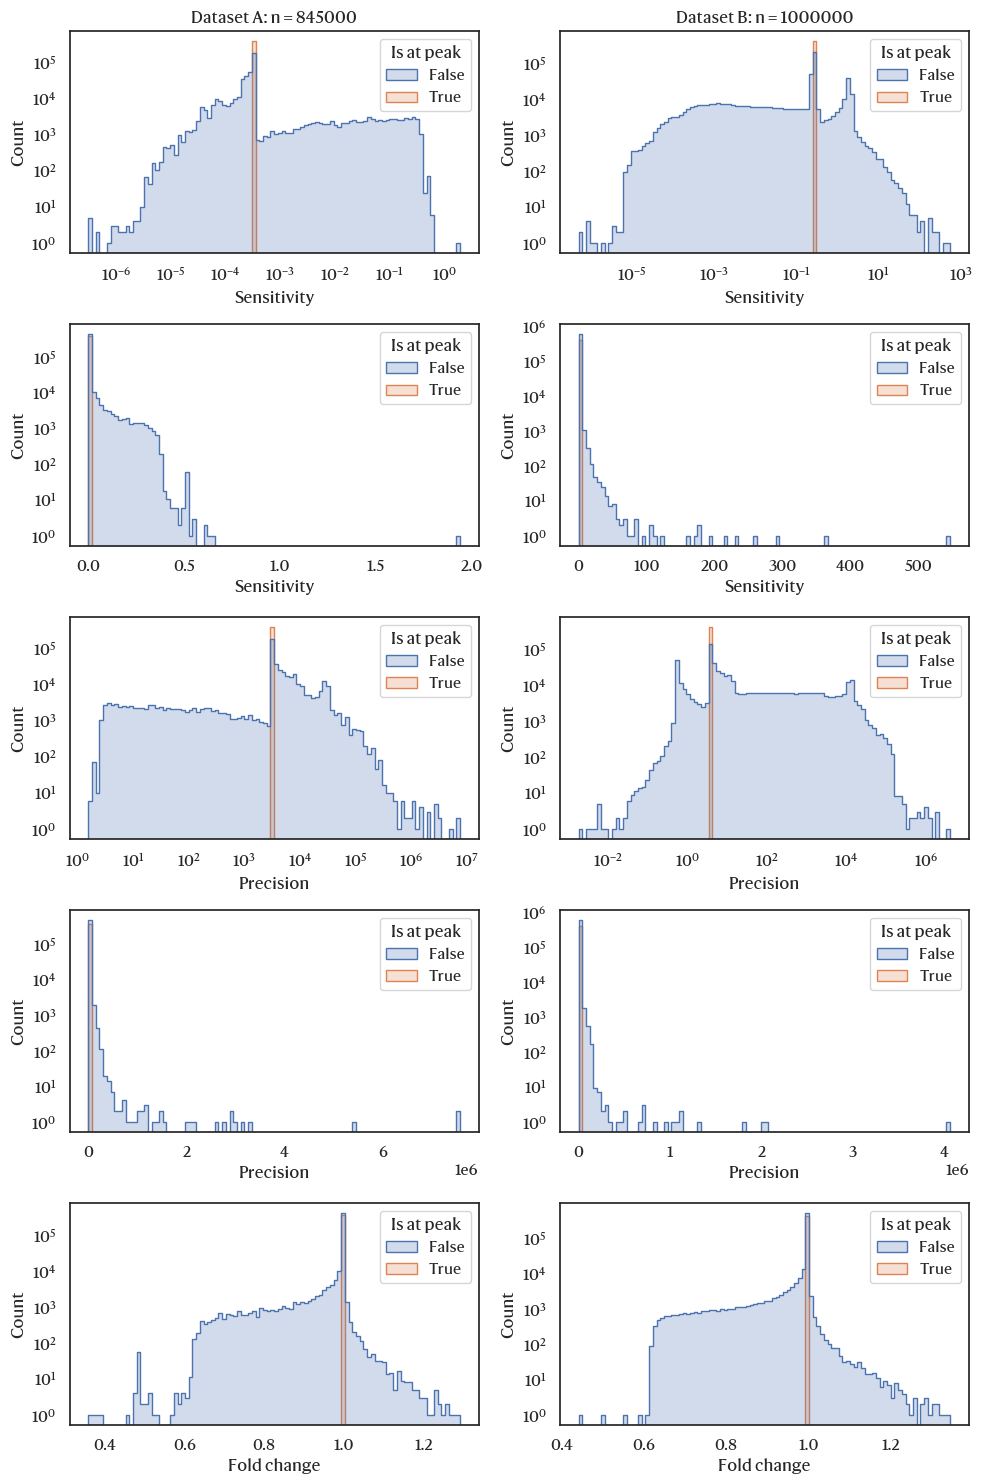

In [62]:
fig, axs = plt.subplots(5, 2, figsize=(5*2, 3*5))

def plot(col, use_log, i):
    filt1 = (df1['sample_name'] == 'RNA_2')
    sns.histplot(df1[filt1], x=col, hue='Is at peak',
                element='step', bins=100, log_scale=(use_log, False), ax=axs[i, 0])
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_xlabel(col.replace('_', ' ').capitalize())
    if i == 0: axs[i, 0].set_title(f'Dataset A: n = {len(df1[filt1])}')
    filt2 = df2['Sample name'] == f'$RNA_3$'
    sns.histplot(df2[filt2], x=col, hue='Is at peak',
                element='step', bins=100, log_scale=(use_log, False), ax=axs[i, 1])
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_xlabel(col.replace('_', ' ').capitalize())
    if i == 0: axs[i, 1].set_title(f'Dataset B: n = {len(df2[filt2])}')
        
ii = 0
for col in ['sensitivity', 'precision']:
    for i, use_log in enumerate((True, False), start=ii):
        plot(col, use_log, i)

    # for i, col in zip([2, 3], ['precision', 'fold_change']):
    #     sns.histplot(df1[filt1], x=col, hue='Is at peak',
    #                  element='step', bins=100, ax=axs[i, 0])
    #     axs[i, 0].set_yscale('log')
    #     sns.histplot(df2[filt2], x=col, hue='Is at peak',
    #                  element='step', bins=100, ax=axs[i, 1])
    #     axs[i, 1].set_yscale('log')
    ii += 2

plot('fold_change', False, 4)

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'sensitivity_peak_histograms.png'), dpi=300,
            bbox_inches='tight')

Text(0.5, 1.0, 'Dataset 2')

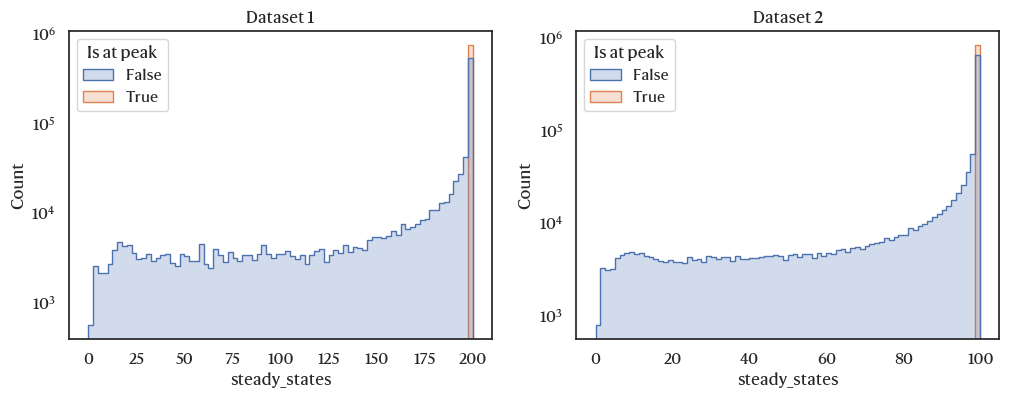

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
sns.histplot(df1[df1['sample_name'] != 'RNA_0'], x='steady_states', 
             hue='Is at peak', element='step', bins=80, ax=axs[0])
            #  hue='sample_name', element='step', bins=80, ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_title('Dataset 1')
sns.histplot(df2[df2['Sample name'] != f'$RNA_1$'], x='steady_states', 
             hue='Is at peak', element='step', bins=80, ax=axs[1])
            #  hue='Sample name', element='step', bins=80, ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Dataset 2')

In [ ]:
# cols_plot = [
#     'sensitivity', 'precision', 'initial_steady_states', 'steady_states', 'fold_change', 'overshoot']

# nrows = 3
# ncols = int(np.ceil(len(cols_plot) / nrows))
# fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))

# for ax, col in zip(axs.flat, cols_plot):
#     sns.histplot(data=df1[df1['sample_name'] != 'RNA_0'], 
#                  x=col, hue='Is at peak', 
#                  bins=100, element='step', ax=ax,
#                  log_scale=(True, False) if col in (
#                      'sensitivity', 'precision') else (False, False))
#     ax.set_yscale('log')
#     ax.set_xlabel(col.replace('_', ' ').capitalize())
#     # ax.set_title(col.replace('_', ' ').title())

# plt.tight_layout()


# Look at binding energies of peak circuits

In [ ]:
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols

cols_e1 = get_true_interaction_cols(df1, 'energies', remove_symmetrical=True)

df2[cols_e1] = np.nan
for i in df2['Sample name'].unique():
    df2.loc[df2['Sample name'] == i, cols_e1] = pd.DataFrame(energies).values

In [51]:
pd.DataFrame(df1[df1['Is at peak']][cols_e1].value_counts())

count
energies_0-0 energies_0-1 energies_0-2 energies_1-1 energies_1-2 energies_2-2        
0.0          0.0          0.0           0.00        0.0           0.00         742084
                                                                 -1.46            182
                                       -1.40        0.0           0.00             96
                                        0.00        0.0          -1.84             38
                                       -1.42        0.0           0.00             29
                                        0.00        0.0          -1.42             14
                                       -1.20        0.0           0.00              7
                                        0.00        0.0          -1.40              5
                                       -1.47        0.0           0.00              4
                                        0.00        0.0          -2.41              4
                                                                 -1.34              4
                                       -1.10        0.0           0.00              3
                                        0.00        0.0          -1.29              2
                                                                 -0.25              2
                                       -1.34        0.0           0.00              2
                                       -2.41        0.0           0.00              1
                                       -0.78        0.0           0.00              1

In [52]:
pd.DataFrame(df2[df2['Is at peak']][cols_e1].value_counts())

count
energies_0-0 energies_0-1 energies_0-2 energies_1-1 energies_1-2 energies_2-2        
0.0          0.0          0.0           0.00        0.0           0.00         824674
                                       -1.53        0.0           0.00              2
                                       -0.29        0.0           0.00              2
                                        0.00        0.0          -1.53              2
                                       -1.29        0.0           0.00              1